# Data Preprocessing

In [23]:
# Importing Necessary Libraries
import os
import cv2
import numpy as np
import re
from matplotlib import pyplot as plt
import pandas as pd

In [24]:
## Function


# Resize

def resize_image(image, width=None, height=None):
    cv2.rectangle(image, (78, 294), (78 + 2089, 294 + 1217), (0, 255, 0), 2)
    roi = image[294:294+1217, 78:78+2089]
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    h, w = roi_rgb.shape[:2]
    aspect_ratio = w / h

    if width is None:
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(roi_rgb, (height, new_height), interpolation=cv2.INTER_AREA)
    else:
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(roi_rgb, (new_width, width), interpolation=cv2.INTER_AREA)

    return resized_image

# Function for taking all the
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])


def normalize_desc(folder):
    text = folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

# For showing the progress of normalizing the label
def print_progress(val, val_len, folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/ ----> file : %s" % (progr, folder, filename), end="\r")



In [25]:
# Setting the dataset path
dataset_dir = "./ECG_Data/"

# Initializing the Array
imgs = []
labels = []
descs = []
raw = []


# Looping for crop, change itu gray scale, and resize the image
for folder in os.listdir(dataset_dir):
    folder_files = os.listdir(os.path.join(dataset_dir, folder))
    len_folder = len(folder_files) - 1
    for i, filename in enumerate(folder_files):
      # Read the image
      images = cv2.imread(os.path.join(dataset_dir, folder, filename), 0)
      
      # Resize the image
      resized_image = resize_image(images, width=250)
      
      # Grayscaling the image
      gray = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
      
      # Adding into the array
      raw.append(images)
      imgs.append(gray)
      labels.append(normalize_label(os.path.splitext(folder)[0]))
      descs.append(normalize_desc(folder))
      
      print_progress(i, len_folder, folder, filename)


[##########] folder : Abnormal_Heartbeat/ ----> file : HB(99).jpgg
[##########] folder : Myocardial_Infarction/ ----> file : MI(99).jpgg


In [26]:
# # Ch3cking the image
# cv2.imshow("abu-abu", raw[0])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

cv2.imshow("abu-abu", imgs[0])

cv2.waitKey(0)
cv2.destroyAllWindows()

In [27]:
# # Chicking the image
# cv2.imshow("abu-abu", imgs[0])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [28]:
# image = cv2.imread("./ECG_Data/Normal_Person/Normal(1).jpg", 0)
# roi_x, roi_y, roi_width, roi_height = 42, 294, 2129, 1217 
# cv2.rectangle(image, (roi_x, roi_y), (roi_x + roi_width, roi_y + roi_height), (0, 255, 0), 2)
# image = cv2.imread("./ECG_Data/Normal_Person/Normal(1).jpg", 0)
# cv2.imshow("Normal(1).jpg", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# roi = image[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
# print(roi)
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
# print(image_rgb)
# print(roi_rgb)
# plt.subplot(1, 2, 2)
# plt.imshow(roi_rgb)
# plt.title("Cropped ROI")
# plt.subplot(1, 2, 2)
# plt.imshow(image_rgb)
# plt.title("Cropped ROI")

# Feature Extraction Using GLCM

In [29]:
# Importing Necessary Libraries
from skimage.feature import graycomatrix, graycoprops

In [30]:

# Function for Calculating the GLCM
def calc_glcm_all_agls(img, label, props, dists=[1], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = graycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


In [31]:
# Declaring the property of GLCM
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []

# Looping for GLCM
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(calc_glcm_all_agls(img, label, props=properties))
    
# Adding the GLCM Feature into array 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

In [32]:
# Converting the 2d Array into dataframe
df = pd.DataFrame(glcm_all_agls, columns = columns)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dissimilarity_0    1120 non-null   float64
 1   dissimilarity_45   1120 non-null   float64
 2   dissimilarity_90   1120 non-null   float64
 3   dissimilarity_135  1120 non-null   float64
 4   correlation_0      1120 non-null   float64
 5   correlation_45     1120 non-null   float64
 6   correlation_90     1120 non-null   float64
 7   correlation_135    1120 non-null   float64
 8   homogeneity_0      1120 non-null   float64
 9   homogeneity_45     1120 non-null   float64
 10  homogeneity_90     1120 non-null   float64
 11  homogeneity_135    1120 non-null   float64
 12  contrast_0         1120 non-null   float64
 13  contrast_45        1120 non-null   float64
 14  contrast_90        1120 non-null   float64
 15  contrast_135       1120 non-null   float64
 16  ASM_0              1120 

In [34]:
df.head()

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,11.166963,15.967243,10.055233,15.758060,0.595674,0.314556,0.625216,0.331310,0.208468,0.126168,...,1475.146211,0.004315,0.004267,0.004948,0.004251,0.065690,0.065325,0.070344,0.065202,AbnormalHeartbeat
1,13.048701,16.481318,9.359751,16.431408,0.484874,0.336187,0.721315,0.337086,0.206713,0.125617,...,1520.694366,0.004138,0.004096,0.004811,0.004086,0.064326,0.064000,0.069358,0.063925,AbnormalHeartbeat
2,13.166047,16.942152,9.793355,16.563281,0.484665,0.295509,0.684822,0.323852,0.205808,0.124883,...,1543.920636,0.004161,0.004128,0.004800,0.004105,0.064508,0.064252,0.069285,0.064067,AbnormalHeartbeat
3,14.405598,17.322270,9.688001,17.024547,0.448795,0.335460,0.731175,0.355294,0.202837,0.124072,...,1608.678659,0.004082,0.004076,0.004771,0.004057,0.063891,0.063845,0.069075,0.063696,AbnormalHeartbeat
4,12.560215,16.287064,9.664036,16.134294,0.501081,0.309317,0.676225,0.319920,0.206167,0.125300,...,1460.050032,0.004174,0.004149,0.004832,0.004117,0.064608,0.064410,0.069512,0.064161,AbnormalHeartbeat


# SVM Modelling

### Data Frame Preprocess

In [35]:
# Importing Necessary Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [36]:
# Splitting the feature
X0 = df.iloc[:, :-1].values
Y0 = df.iloc[:, -1].values

In [37]:
print(len(Y0))
print(len(X0))

1120
1120


In [38]:
# # Encoding the label
# le = LabelEncoder()
# Y0 = le.fit_transform(Y0)
# print(Y0)

In [39]:
# Splitting the dataset into train and test

X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, train_size = 0.8, test_size = 0.2, random_state = 101)
print(f"train size : {len(X0_train) + len(Y0_train)}")
print(f"test size : {len(X0_test) + len(Y0_test)}")

train size : 1792
test size : 448


In [40]:
## Normalization of the Independent feature

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the data and transform it
scaler.fit(X0_train)
scaler.transform(X0_train)

# Export the scaler
scalerfile = './website/scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

## Training Model

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

### Modelling the SVM Training

In [45]:
# Default SVM

classifier1 = SVC(kernel='rbf', random_state = 100)
classifier1.fit(X0_train, Y0_train)

SVC(random_state=100)

In [46]:
# Grid Search SVM Model

param_grid = {'C' : [0.1, 1, 10, 100, 1000],
        'gamma' : [1, 0.1, 0.001, 0.0001],
        'kernel' : ['rbf']}

classifier2 = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
classifier2.fit(X0_train, Y0_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.539 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.564 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.553 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.564 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.559 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.539 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.564 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.553 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.603 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.559 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.611 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['rbf']},
             verbose=3)

In [47]:

# Initialize the KFold object with 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the list to store the scores
scores = []

# Initialize the best parameters and best score
best_params = None
best_score = 0

# Loop through each fold
for train_index, val_index in kfold.split(X0_train):
    # Split the data into training and validation sets
    X_train_fold = X0_train[train_index]
    Y_train_fold = Y0_train[train_index]
    X_val_fold = X0_train[val_index]
    Y_val_fold = Y0_train[val_index]

    # Perform grid search
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.001, 0.0001],
                  'kernel': ['rbf']}
    classifier3 = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
    classifier3.fit(X_train_fold, Y_train_fold)

    # Evaluate the model on the validation set
    Y_pred_fold = classifier3.predict(X_val_fold)
    score = accuracy_score(Y_val_fold, Y_pred_fold)
    scores.append(score)

    # Update the best parameters and best score if necessary
    if score > best_score:
        best_params = classifier3.best_params_
        best_score = score

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.451 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.455 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.462 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.469 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.476 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.451 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.455 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.462 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.469 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.476 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.556 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf

### Testing the SVM Training

In [48]:

# Assuming you have trained your model and obtained the predicted labels
y_train_pred = classifier1.predict(X0_train)

# Calculate the accuracy score
train_accuracy = accuracy_score(Y0_train, y_train_pred)

# Print the training accuracy
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.6149553571428571


In [49]:

# Assuming you have trained your model and obtained the predicted labels
y_train_pred = classifier2.predict(X0_train)

# Calculate the accuracy score
train_accuracy = accuracy_score(Y0_train, y_train_pred)

# Print the training accuracy
print("Training Accuracy:", train_accuracy)
print("Best Parameters:", classifier2.best_params_)
print("Best Score:", classifier2.best_score_)

Training Accuracy: 0.9988839285714286
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.9720856610800744


In [50]:
# Calculate the average score across all folds
average_score = np.mean(scores)
print(f"Average Accuracy: {average_score:.8f}")
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Average Accuracy: 0.96318436
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.9776536312849162


## Testing Model

In [51]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score, precision_score, recall_score
import seaborn as sns

                      precision    recall  f1-score   support

   AbnormalHeartbeat       0.79      0.79      0.79        75
MyocardialInfarction       0.00      0.00      0.00        70
        NormalPerson       0.50      0.95      0.66        79

            accuracy                           0.60       224
           macro avg       0.43      0.58      0.48       224
        weighted avg       0.44      0.60      0.50       224

0.5982142857142857
[[59  0 16]
 [12  0 58]
 [ 4  0 75]]


c:\Users\ANDREAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ANDREAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ANDREAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

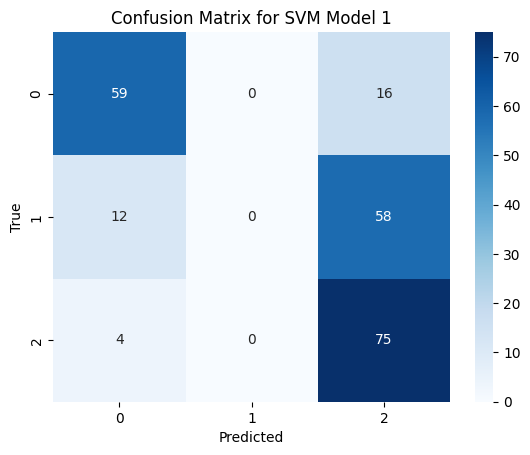

In [52]:
## Classifier 1

Y0_pred1 = classifier1.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred1))
print(accuracy_score(Y0_test, Y0_pred1))
print(confusion_matrix(Y0_test, Y0_pred1))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred1)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model 1')

# Show the plot
plt.show()


                      precision    recall  f1-score   support

   AbnormalHeartbeat       0.97      0.97      0.97        75
MyocardialInfarction       0.96      1.00      0.98        70
        NormalPerson       1.00      0.96      0.98        79

            accuracy                           0.98       224
           macro avg       0.98      0.98      0.98       224
        weighted avg       0.98      0.98      0.98       224

0.9776785714285714
[[73  2  0]
 [ 0 70  0]
 [ 2  1 76]]


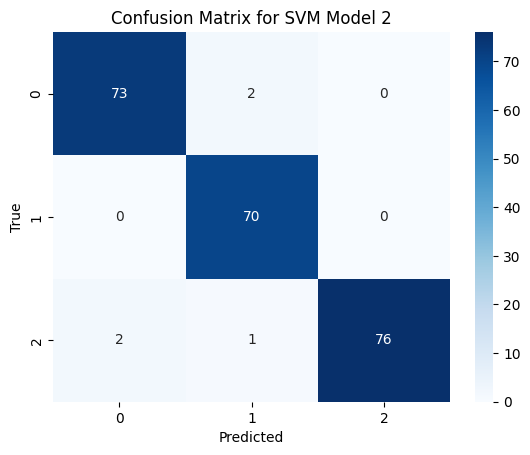

In [53]:
## Classifier 2

Y0_pred2 = classifier2.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred2))
print(accuracy_score(Y0_test, Y0_pred2))
print(confusion_matrix(Y0_test, Y0_pred2))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred2)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model 2')

# Show the plot
plt.show()


                      precision    recall  f1-score   support

   AbnormalHeartbeat       0.95      0.97      0.96        75
MyocardialInfarction       0.96      1.00      0.98        70
        NormalPerson       1.00      0.94      0.97        79

            accuracy                           0.97       224
           macro avg       0.97      0.97      0.97       224
        weighted avg       0.97      0.97      0.97       224

0.96875
[[73  2  0]
 [ 0 70  0]
 [ 4  1 74]]


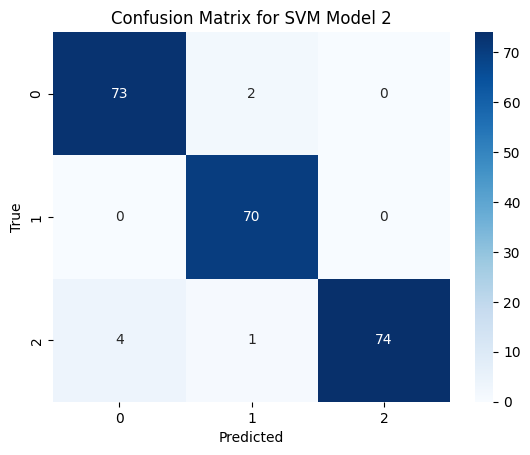

In [54]:
## Classifier 3

Y0_pred3 = classifier3.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred3))
print(accuracy_score(Y0_test, Y0_pred3))
print(confusion_matrix(Y0_test, Y0_pred3))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred3)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model 2')

# Show the plot
plt.show()

### Export the model

In [2]:
#Importing the scaler
scalerfile = './website/scaler.sav'
scaler = pickle.load(open(scalerfile, 'rb'))
test_scaled_set = scaler.transform(X0_test)

NameError: name 'pickle' is not defined

In [ ]:
## Looking at classification report

Y0_pred = classifier1.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred))
print(accuracy_score(Y0_test, Y0_pred))
print(confusion_matrix(Y0_test, Y0_pred))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM Model 1')

# Show the plot
plt.show()


# SVM Parameter Tuning

In [ ]:
# Importing Necessary Libraries
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000],
        'gamma' : [1, 0.1, 0.001, 0.0001],
        'kernel' : ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X0_train, Y0_train)
# Assuming you have already performed GridSearchCV and stored the results in grid

# Extract the relevant information from cv_results_
results = grid.cv_results_
param_columns = ['param_C', 'param_gamma', 'param_kernel']
score_column = 'mean_test_score'

# Create a DataFrame with the desired columns
cnth = pd.DataFrame(results, columns=param_columns + [score_column])

cnth.to_excel("result.xlsx", index=False)


In [ ]:
best_param = grid.best_params_

# Create a new SVM model with the best parameters
best_svm_model = SVC(**best_param)

# Fit the model with the best parameters to the data
best_svm_model.fit(X0_train, Y0_train)

In [ ]:
Y0_pred = best_svm_model.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred))
print(f"Akurasi: {accuracy_score(Y0_test, Y0_pred)}")
print(f"Precision: {precision_score(Y0_test, Y0_pred, average='weighted')}")
print(f"Recall: {recall_score(Y0_test, Y0_pred, average='weighted')}")
print(f"F1 Score: {f1_score(Y0_test, Y0_pred, average='weighted')}")
print(confusion_matrix(Y0_test, Y0_pred))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# K Fold Cross Validation

In [ ]:
Y0_pred = kfold_grid.predict(X0_test)
# test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
# print(test)
print(classification_report(Y0_test, Y0_pred))
print(f"Akurasi: {accuracy_score(Y0_test, Y0_pred)}")
print(f"Precision: {precision_score(Y0_test, Y0_pred, average='weighted')}")
print(f"Recall: {recall_score(Y0_test, Y0_pred, average='weighted')}")
print(f"F1 Score: {f1_score(Y0_test, Y0_pred, average='weighted')}")
print(confusion_matrix(Y0_test, Y0_pred))

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(Y0_test, Y0_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Assuming you have the true labels Y0_test and predicted labels Y0_pred
report = classification_report(Y0_test, Y0_pred)

# Convert the report to a DataFrame
report_df = pd.DataFrame(classification_report(Y0_test, Y0_pred, output_dict=True)).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv('./website/classification_report.csv', index=True)

# Save Confusion Matrix
cm_df = pd.DataFrame(cm)
cm_df.to_csv('./website/confusion_matrix.csv', index=True)

In [ ]:
test = np.concatenate((Y0_pred.reshape(len(Y0_pred),1), Y0_test.reshape(len(Y0_test),1)),1)
print(test)

In [ ]:
To compare the accuracy of a trained model, you can use the `accuracy_score` function from the `sklearn.metrics` module. Here's an example of how to compare the accuracy of two models:

```python
from sklearn.metrics import accuracy_score

# Assuming you have two trained models: model1 and model2
y_pred1 = model1.predict(X0_test)
y_pred2 = model2.predict(X0_test)
y_pred3 = 

# Calculate the accuracy scores
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)

# Compare the accuracy scores
if accuracy1 > accuracy2:
  print("Model 1 has higher accuracy.")
elif accuracy2 > accuracy1:
  print("Model 2 has higher accuracy.")
else:
  print("Both models have the same accuracy.")
```


In [ ]:

# Assuming you have a trained model called 'model'
model = best_svm_model

# Specify the file path where you want to save the pickle file
file_path = './website/model.pkl'
file_path2 = '/model.pkl'

# Export the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model, file)
    
with open(file_path2, 'wb') as file:
    pickle.dump(model, file)

In [ ]:

joblib.dump(best_svm_model, './website/jbmodel.joblib')

In [ ]:
#Accuracy on saved model
loaded_model = joblib.load('./website/jbmodel.joblib')
result = loaded_model.score(X0_test, Y0_test)

# confusion matrix
pred = loaded_model.predict(X0_test)
cm = confusion_matrix(Y0_test, pred)

print(f"Accuracy: {result}")
print(f"Confusion Matrix: \n{cm}")